# download data

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
import pandas as pd
import numpy as np

In [5]:
cd /home/paperspace/data/

/home/paperspace/data


In [6]:
#Need to first go to Kaggle website and accept rules for the competition!
#!kg download -u superexistential -p XXXXXXXXX -c state-farm-distracted-driver-detection

downloading https://www.kaggle.com/c/state-farm-distracted-driver-detection/download/sample_submission.csv.zip

sample_submission.csv.zip 100% |####################| Time: 0:00:00 495.8 KiB/s

downloading https://www.kaggle.com/c/state-farm-distracted-driver-detection/download/imgs.zip

imgs.zip 100% |#####################################| Time: 0:01:41  40.4 MiB/s

downloading https://www.kaggle.com/c/state-farm-distracted-driver-detection/download/driver_imgs_list.csv.zip

driver_imgs_list.csv.zip 100% |#####################| Time: 0:00:00 187.0 KiB/s



In [7]:
!mkdir ./statefarm
!mv imgs.zip ./statefarm/
!mv driver_imgs_list.csv.zip ./statefarm/
!mv sample_submission.csv.zip ./statefarm/

In [8]:
PATH='/home/paperspace/data/statefarm/'

In [9]:
%cd $PATH

/home/paperspace/data/statefarm


In [10]:
!unzip -q imgs.zip
!unzip -q driver_imgs_list.csv.zip
!rm imgs.zip
!rm driver_imgs_list.csv.zip


In [11]:
#I want to try the from-csv approach, so I'm putting all the images in the train subfolders 
#back into the train main folder
for i in range(10):
    nupath=PATH+'train/c' + str(i)
    %cd $nupath
    g=glob('*.jpg')
    shuf = np.random.permutation(g)
    for j in range(len(shuf)):
        os.rename(shuf[j], PATH+'train/'+shuf[j])
        #shutil.copy(shuf[j], path+'valid/c'+str(i))


/home/paperspace/data/statefarm/train/c0
/home/paperspace/data/statefarm/train/c1
/home/paperspace/data/statefarm/train/c2
/home/paperspace/data/statefarm/train/c3
/home/paperspace/data/statefarm/train/c4
/home/paperspace/data/statefarm/train/c5
/home/paperspace/data/statefarm/train/c6
/home/paperspace/data/statefarm/train/c7
/home/paperspace/data/statefarm/train/c8
/home/paperspace/data/statefarm/train/c9


# simple Howard-style analysis w/ resnet

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import pandas as pd
import numpy as np

In [3]:
sz=224
arch=resnet34
bs=30

In [4]:
PATH='/home/paperspace/data/statefarm/'

In [5]:
label_csv = f'{PATH}driver_imgs_list.csv'
tempcsv=pd.read_csv(label_csv)

In [6]:
tempcsv.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [7]:
newcsv=tempcsv[['img','classname']]
newcsv.head()

,img,classname
0,img_44733.jpg,c0
1,img_72999.jpg,c0
2,img_25094.jpg,c0
3,img_69092.jpg,c0
4,img_92629.jpg,c0


In [8]:
newcsv.to_csv(f'{PATH}short_list.csv',columns=['img','classname'],index=False)

In [9]:
label_csv = f'{PATH}short_list.csv'
n=len(list(open(label_csv)))-1 #number of images
val_idxs = get_cv_idxs(n) #get_cv_idxs(n, cv_idx=0, val_pct=0.2, seed=42)... This grabs 20% of the indices at random for validation
np.shape(val_idxs)

(4484,)

In [10]:
label_df=pd.read_csv(label_csv)

In [11]:
label_df.head()

,img,classname
0,img_44733.jpg,c0
1,img_72999.jpg,c0
2,img_25094.jpg,c0
3,img_69092.jpg,c0
4,img_92629.jpg,c0


In [12]:
label_df.pivot_table(index='classname',aggfunc=len).sort_values('img')

,img
classname,
c8,1911
c7,2002
c9,2129
c1,2267
c5,2312
c2,2317
c6,2325
c4,2326
c3,2346


In [13]:
tfms=tfms_from_model(arch,sz,aug_tfms=transforms_side_on,max_zoom=1.1)
data=ImageClassifierData.from_csv(PATH,'train',f'{PATH}short_list.csv',test_name='test',
                                  val_idxs=val_idxs,tfms=tfms,bs=bs)

In [54]:
fn=PATH+data.trn_ds.fnames[0]

In [55]:
fn

'/home/paperspace/data/statefarm/train/img_0.jpg'

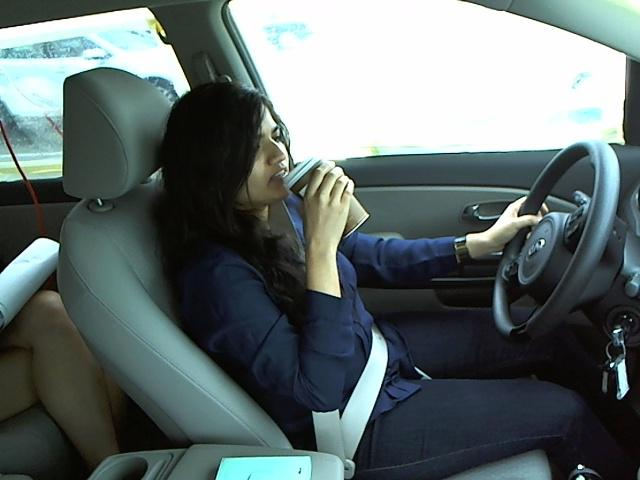

In [56]:
img=PIL.Image.open(fn);img

In [60]:
img.size

(640, 480)

In [12]:
size_d={k:PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames} #dictionary comprehension... study this!
#this maps the name of the file to the size of the file

In [15]:
row_sz,col_sz=list(zip(*size_d.values()))#zip (study this too!) turns the dictionary into the rows and columns

In [16]:
row_sz=np.array(row_sz); col_sz=np.array(col_sz)

In [64]:
row_sz[:5]

array([640, 640, 640, 640, 640])

(array([    0.,     0.,     0.,     0.,     0., 17940.,     0.,     0.,     0.,     0.]),
 array([639.5, 639.6, 639.7, 639.8, 639.9, 640. , 640.1, 640.2, 640.3, 640.4, 640.5]),
 <a list of 10 Patch objects>)

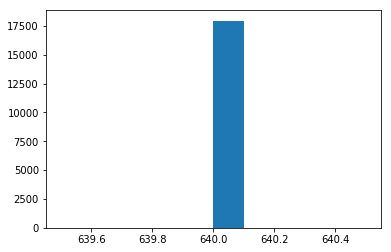

In [66]:
plt.hist(row_sz) #all the images are about the right size

(array([    0.,     0.,     0.,     0.,     0., 17940.,     0.,     0.,     0.,     0.]),
 array([479.5, 479.6, 479.7, 479.8, 479.9, 480. , 480.1, 480.2, 480.3, 480.4, 480.5]),
 <a list of 10 Patch objects>)

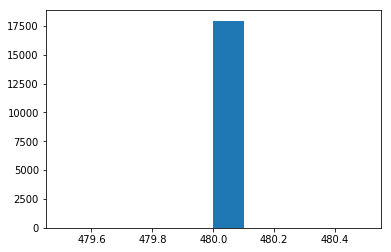

In [67]:
plt.hist(col_sz)

In [57]:
len(data.trn_ds), len(data.test_ds)

(17940, 79726)

In [58]:
len(data.classes), data.classes[:5]

(10, ['c0', 'c1', 'c2', 'c3', 'c4'])

In [11]:
def get_data(sz,bs): #passing a small image size will speed everything up very quickly!
    tfms=tfms_from_model(arch,sz,aug_tfms=transforms_side_on,max_zoom=1.1)
    data=ImageClassifierData.from_csv(PATH,'train',f'{PATH}short_list.csv',test_name='test',num_workers=4,
                                  val_idxs=val_idxs,tfms=tfms,bs=bs)
    return data if sz>300 else data.resize(340,'tmp')

In [12]:
sz=64

In [13]:
data=get_data(sz,bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [14]:
learn=ConvLearner.pretrained(arch,data,precompute=True)

In [76]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 81%|████████  | 251/310 [00:04<00:00, 61.47it/s, loss=8.65]


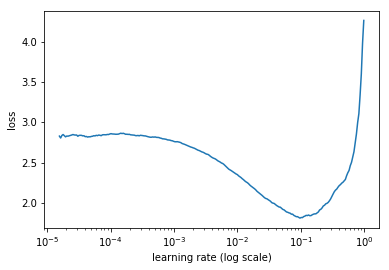

In [77]:
learn.sched.plot()

In [15]:
learn.fit(1e-2,5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch:   0, train_loss: 0.896173, val_loss: 0.472920, accuracy: 0.862381
epoch:   1, train_loss: 0.705167, val_loss: 0.317324, accuracy: 0.909524
epoch:   2, train_loss: 0.545301, val_loss: 0.245912, accuracy: 0.929937
epoch:   3, train_loss: 0.483294, val_loss: 0.207277, accuracy: 0.941968
epoch:   4, train_loss: 0.441754, val_loss: 0.197562, accuracy: 0.944190



In [16]:
learn.save('128_pre')

In [17]:
#everything looks like its running fine, so lets set sz to 128
bs=20
sz=128


In [20]:
learn.set_data(get_data(sz,bs)) # set training image size to larger (299)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [30]:
#learn.precompute=False #setting to false so data augmentation works

In [21]:
learn.fit(1e-2,5,cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch:   0, train_loss: 0.278782, val_loss: 0.134805, accuracy: 0.969111
epoch:   1, train_loss: 0.271055, val_loss: 0.151067, accuracy: 0.965524
epoch:   2, train_loss: 0.277429, val_loss: 0.154732, accuracy: 0.965111
epoch:   3, train_loss: 0.265736, val_loss: 0.134239, accuracy: 0.969302
epoch:   4, train_loss: 0.271140, val_loss: 0.124991, accuracy: 0.968000



In [22]:
learn.save('128_pre')

In [23]:
log_preds,y=learn.TTA()
probs=np.exp(log_preds)
accuracy(log_preds,y),metrics.log_loss(y,probs)

AttributeError: 'bool' object has no attribute 'mean'